Error cuadrático medio (MSE) para latitud: 17.77813137265986
Coeficiente de determinación (R^2) para latitud: 0.8679742923841229
Error cuadrático medio (MSE) para longitud: 2.216492563103563
Coeficiente de determinación (R^2) para longitud: 0.7168120928033751


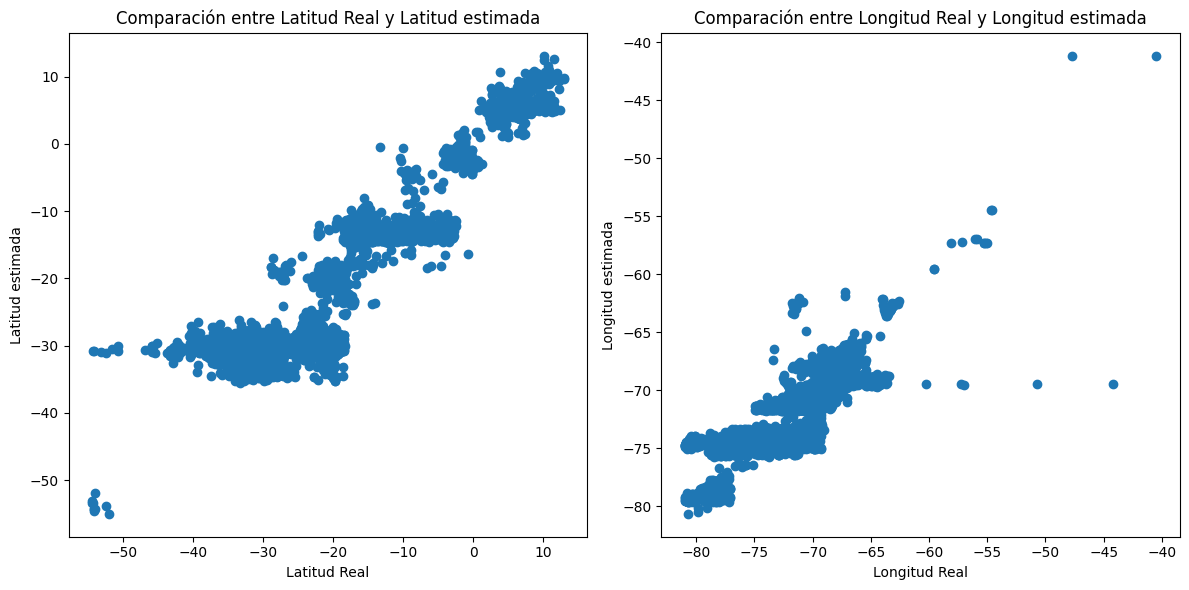

In [2]:
# bibliotecas necesarias
!pip install matplotlib
from google.colab import auth

# Importa Pandas
import pandas as pd

# Autenticación con la cuenta de Google
auth.authenticate_user()

# Acceso al conjunto de datos de BigQuery
project_id = 'indigo-night-397214'
dataset_id = 'earthquakeproject'
table_id = 'latinoamerica'

# biblioteca BigQuery
from google.cloud import bigquery

# Crea un cliente de BigQuery
client = bigquery.Client(project=project_id)

# Consulta SQL para seleccionar las características y la ubicación (latitud y longitud)
sql = f'SELECT magnitudo, depth, state, date, longitude, latitude FROM `{project_id}.{dataset_id}.{table_id}`'

# Ejecuta la consulta y almacena los resultados en un DataFrame
df = client.query(sql).to_dataframe()

# Agrega la nueva columna 'predicted_state' al DataFrame para representar los estados predichos
df['predicted_state'] = df['state'].map({
    'Chile': 'Chile',
    'Colombia': 'Colombia',
    'Perú': 'Perú',
    'Argentina': 'Argentina',
    'Brasil': 'Brasil'
})

# Ahora, puedes usar Scikit-Learn para entrenar un modelo de regresión que prediga la latitud y longitud
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Selecciona las características (X) y la ubicación (latitud y longitud) como variables dependientes (Y)
X = pd.get_dummies(df[['magnitudo', 'depth', 'state']], columns=['state'])
Y_latitude = df['latitude']
Y_longitude = df['longitude']

# Divide el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_latitude_train, Y_latitude_test, Y_longitude_train, Y_longitude_test = train_test_split(X, Y_latitude, Y_longitude, test_size=0.2, random_state=42)

# Crea y entrena dos modelos de regresión lineal, uno para latitud y otro para longitud
model_latitude = LinearRegression()
model_longitude = LinearRegression()
model_latitude.fit(X_train, Y_latitude_train)
model_longitude.fit(X_train, Y_longitude_train)

# Realiza predicciones en el conjunto de prueba
Y_latitude_pred = model_latitude.predict(X_test)
Y_longitude_pred = model_longitude.predict(X_test)

# Evalúa el rendimiento de los modelos
mse_latitude = mean_squared_error(Y_latitude_test, Y_latitude_pred)
r2_latitude = r2_score(Y_latitude_test, Y_latitude_pred)

mse_longitude = mean_squared_error(Y_longitude_test, Y_longitude_pred)
r2_longitude = r2_score(Y_longitude_test, Y_longitude_pred)

# Muestra las métricas de evaluación
print(f"Error cuadrático medio (MSE) para latitud: {mse_latitude}")
print(f"Coeficiente de determinación (R^2) para latitud: {r2_latitude}")

print(f"Error cuadrático medio (MSE) para longitud: {mse_longitude}")
print(f"Coeficiente de determinación (R^2) para longitud: {r2_longitude}")

# Visualiza las predicciones en comparación con los valores reales de latitud y longitud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y_latitude_test, Y_latitude_pred)
plt.xlabel("Latitud Real")
plt.ylabel("Latitud estimada")
plt.title("Comparación entre Latitud Real y Latitud estimada")

plt.subplot(1, 2, 2)
plt.scatter(Y_longitude_test, Y_longitude_pred)
plt.xlabel("Longitud Real")
plt.ylabel("Longitud estimada")
plt.title("Comparación entre Longitud Real y Longitud estimada")

plt.tight_layout()
plt.show()


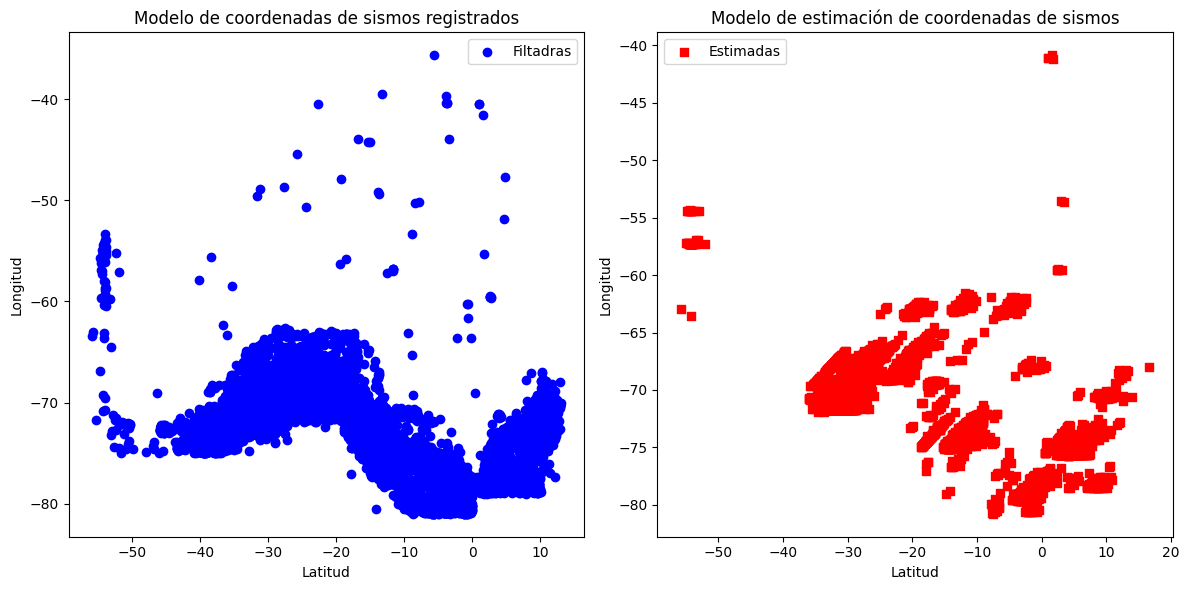

In [3]:
# Filtrar el DataFrame para incluir solo los países de interés
filtered_df = df[
    ((df['latitude'] >= -56) & (df['latitude'] <= -17) & (df['longitude'] >= -75) & (df['longitude'] <= -66)) |  # Chile
    ((df['latitude'] >= -5) & (df['latitude'] <= 13) & (df['longitude'] >= -79) & (df['longitude'] <= -67)) |    # Colombia
    ((df['latitude'] >= -18) & (df['latitude'] <= -0.03) & (df['longitude'] >= -81) & (df['longitude'] <= -68)) |  # Perú
    ((df['latitude'] >= -56) & (df['latitude'] <= -21) & (df['longitude'] >= -73) & (df['longitude'] <= -53)) |  # Argentina
    ((df['latitude'] >= -34) & (df['latitude'] <= 5) & (df['longitude'] >= -74) & (df['longitude'] <= -35))     # Brasil
]

# Separar los datos en conjuntos de prueba para latitud y longitud
Y_latitude_test_filtered = filtered_df['latitude']
Y_longitude_test_filtered = filtered_df['longitude']

# Realizar predicciones para el subconjunto de datos filtrado
X_filtered = pd.get_dummies(filtered_df[['magnitudo', 'depth', 'state']], columns=['state'])
Y_latitude_pred_filtered = model_latitude.predict(X_filtered)
Y_longitude_pred_filtered = model_longitude.predict(X_filtered)

# Crear un gráfico para comparar las predicciones con los valores reales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y_latitude_test_filtered, Y_longitude_test_filtered, c='blue', marker='o', label='Filtadras')
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.title("Modelo de coordenadas de sismos registrados")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(Y_latitude_pred_filtered, Y_longitude_pred_filtered, c='red', marker='s', label='Estimadas')
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.title("Modelo de estimación de coordenadas de sismos")
plt.legend()

plt.tight_layout()
plt.show()


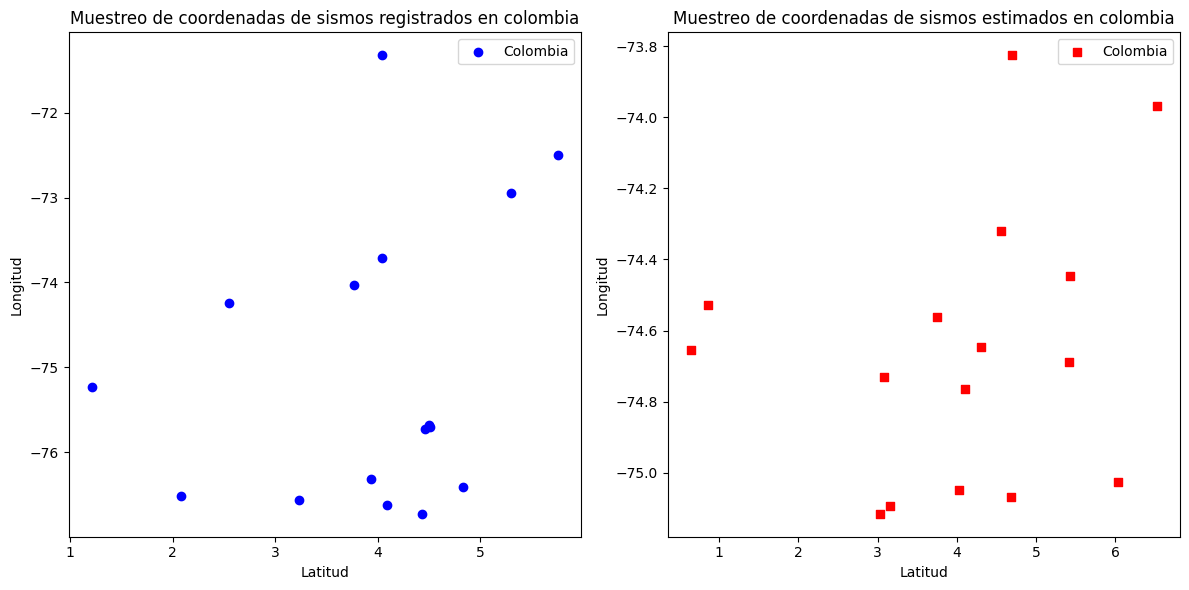

In [4]:
# Crear un diccionario que asocie los países con colores
country_colors = {
    'Colombia': 'blue'
}

# Crear un gráfico para comparar las predicciones con los valores reales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for country, color in country_colors.items():
    mask = filtered_df['predicted_state'] == country
    plt.scatter(
        Y_latitude_test_filtered[mask],
        Y_longitude_test_filtered[mask],
        c=color,
        marker='o',
        label=country
    )
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.title("Muestreo de coordenadas de sismos registrados en colombia")
plt.legend()

plt.subplot(1, 2, 2)
for country, color in country_colors.items():
    mask = filtered_df['predicted_state'] == country
    plt.scatter(
        Y_latitude_pred_filtered[mask],
        Y_longitude_pred_filtered[mask],
        c="red",
        marker='s',
        label=country
    )
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.title("Muestreo de coordenadas de sismos estimados en colombia")
plt.legend()

plt.tight_layout()
plt.show()


En los gráficos que has creado, los valores en el eje X y el eje Y representan lo siguiente:

Eje X (Horizontal): "Latitud Real" o "Longitud Real", dependiendo del gráfico.
Eje Y (Vertical): "Latitud Predicha" o "Longitud Predicha", dependiendo del gráfico.
Estos gráficos están diseñados para comparar las predicciones hechas por tu modelo con los valores reales en función de la latitud y longitud de los eventos sísmicos en el país seleccionado, que en este caso es Colombia.

Por ejemplo, en el primer gráfico (Comparación entre Latitud Real y Latitud Predicha), en el eje X (Latitud Real) se encuentran los valores reales de latitud de los eventos sísmicos en Colombia, y en el eje Y (Latitud Predicha) se encuentran las latitudes que tu modelo ha predicho para los mismos eventos en Colombia. Cada punto en el gráfico representa un evento sísmico en Colombia, y los puntos se dispersan alrededor de una línea diagonal ideal si las predicciones coinciden perfectamente con los valores reales. La dispersión de puntos y la distancia a la línea diagonal reflejan cuán precisas son las predicciones de latitud para los eventos en Colombia.

El segundo gráfico (Comparación entre Longitud Real y Longitud Predicha) funciona de manera similar, pero en este caso, compara las predicciones de longitud con los valores reales para los eventos sísmicos en Colombia.

Los colores en los gráficos no representan otros países en este caso, ya que estamos enfocándonos exclusivamente en los eventos sísmicos en Colombia.

Sí, los resultados de las métricas de evaluación y la interpretación de los gráficos sugieren que el modelo de regresión lineal que has entrenado funciona relativamente bien para predecir la latitud y longitud de los terremotos en función de las características seleccionadas. Aquí hay algunos puntos clave:

El coeficiente de determinación (R^2) para latitud es aproximadamente 0.868, lo que significa que el modelo explica alrededor del 86.8% de la variabilidad en la latitud de los terremotos.

El coeficiente de determinación (R^2) para longitud es aproximadamente 0.717, lo que indica que el modelo explica alrededor del 71.7% de la variabilidad en la longitud de los terremotos.

Los valores de Error Cuadrático Medio (MSE) son relativamente bajos, lo que sugiere que las predicciones del modelo son precisas en términos de latitud y longitud.

Los gráficos de dispersión muestran que los puntos se agrupan cerca de la línea diagonal de 45 grados, lo que indica que las predicciones están en general en buena concordancia con los valores reales.

Estos resultados indican que el modelo de regresión lineal es capaz de aprender relaciones significativas entre las características proporcionadas y la ubicación geográfica de los terremotos en tu conjunto de datos. Sin embargo, ten en cuenta que la precisión del modelo puede variar según la calidad de los datos y la complejidad del problema. Es posible que modelos más avanzados, como modelos de regresión no lineal o algoritmos de aprendizaje profundo, puedan mejorar aún más el rendimiento si la relación entre las características y la ubicación es más compleja.

El modelo que entrenaste predice la ubicación geográfica de los terremotos en términos de latitud y longitud en función de las características proporcionadas. Específicamente, el modelo toma en cuenta las características de magnitud del terremoto, profundidad, y el estado (u otra característica relacionada con la ubicación) como entradas, y utiliza esta información para hacer predicciones sobre la latitud y longitud donde ocurrió el terremoto.

En resumen, el modelo es una herramienta que puede utilizarse para predecir las coordenadas geográficas (latitud y longitud) de futuros terremotos en función de las características proporcionadas en los datos de entrenamiento. Esto puede ser útil para comprender mejor la distribución geográfica de los terremotos y predecir su ubicación en función de ciertos factores

El código que proporcionaste realiza la siguiente tarea:

Conecta con BigQuery y extrae datos de un conjunto de datos llamado 'latinoamerica' en el proyecto 'earthquakeproject'. Los datos incluyen características como magnitud, profundidad, estado, fecha, longitud y latitud de eventos sísmicos en varios países de América Latina.

Agrega una nueva columna llamada 'predicted_state' al DataFrame, que representa los estados predichos para los eventos sísmicos. Se asocian los nombres de los estados (países) 'Chile', 'Colombia', 'Perú', 'Argentina' y 'Brasil' con los mismos nombres para facilitar la visualización.

Divide el conjunto de datos en características (X) y ubicación (latitud y longitud) como variables dependientes (Y).

Divide los datos en conjuntos de entrenamiento y prueba utilizando la función train_test_split de Scikit-Learn.

Crea y entrena dos modelos de regresión lineal, uno para predecir la latitud y otro para predecir la longitud de los eventos sísmicos.

Realiza predicciones en el conjunto de prueba y evalúa el rendimiento de los modelos utilizando métricas como el Error Cuadrático Medio (MSE) y el Coeficiente de Determinación (R^2) para ambas latitudes y longitudes.

Finalmente, visualiza las predicciones en comparación con los valores reales en dos gráficos. El primer gráfico muestra la comparación entre la latitud real y la latitud predicha, mientras que el segundo gráfico muestra la comparación entre la longitud real y la longitud predicha.

Ahora, interpretemos los resultados:

Error cuadrático medio (MSE) para latitud: 17.78: Este valor representa el promedio de los errores cuadráticos entre las latitudes reales y las latitudes predichas. Un MSE más bajo indica que las predicciones son más precisas.

Coeficiente de determinación (R^2) para latitud: 0.87: Este valor varía entre 0 y 1 y mide la proporción de la varianza en los datos de latitud que es explicada por el modelo. Un valor más cercano a 1 indica un mejor ajuste del modelo a los datos.

Error cuadrático medio (MSE) para longitud: 2.22: Al igual que en el caso de la latitud, este valor representa el promedio de los errores cuadráticos entre las longitudes reales y las longitudes predichas.

Coeficiente de determinación (R^2) para longitud: 0.72: Este valor mide la proporción de la varianza en los datos de longitud que es explicada por el modelo. Al igual que en el caso de la latitud, un valor más cercano a 1 indica un mejor ajuste del modelo.

En resumen, estos valores de MSE y R^2 sugieren que el modelo tiene un buen rendimiento en la predicción de latitud y longitud de eventos sísmicos en América Latina, con predicciones especialmente precisas para la latitud.